# A pipline to do regression analysis using ML in Python

In [25]:
# Search the name of the pkgs for their usages
import os
import numpy as np
import pandas as pd 
import pandas_profiling as pd_profile
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt 
%matplotlib inline

## Load and explore the data sets
In this section, we assume that the data only contains features and outcome. When other nuisance variables are also in the data, you can refer the pandas tutorial to see how to remove them.

In [4]:
# read into the data sets
# path to the data 
path2data = './data/titanic.csv'

# if the first column is not the index (ID) of the data, remove "index_col=0"
data = pd.read_csv(path2data, index_col=0) 
print('data size is {}'.format(data.shape))

data size is (891, 11)


In [5]:
# summarize the data set
# save the report to the results fold
if not os.path.isdir('results'):
    os.mkdir('results')
path2report = './results/data_profile_report.html'

# save the data exploration report
if os.path.isfile(path2report):
    print('Report is already exist.')
else:
    # only summarize at most 1000 samples
    profile_report = pd_profile.ProfileReport(
                                        data.sample(min(1000, data.shape[0])),
                                        minimal=True)
    profile_report.to_file(path2report) 

Report is already exist.


## Preprocess the data sets for ML model

In [6]:
# show an example of the data
data.sample(5)

Survived  Pclass                               Name     Sex  \
PassengerId                                                                
721                 1       2  Harper, Miss. Annie Jessie "Nina"  female   
801                 0       2               Ponesell, Mr. Martin    male   
740                 0       3                 Nankoff, Mr. Minko    male   
264                 0       1              Harrison, Mr. William    male   
815                 0       3         Tomlin, Mr. Ernest Portage    male   

              Age  SibSp  Parch  Ticket     Fare Cabin Embarked  
PassengerId                                                      
721           6.0      0      1  248727  33.0000   NaN        S  
801          34.0      0      0  250647  13.0000   NaN        S  
740           NaN      0      0  349218   7.8958   NaN        S  
264          40.0      0      0  112059   0.0000   B94        S  
815          30.5      0      0  364499   8.0500   NaN        S

In [7]:
# Rmove the samples contains missing values in outcome y
# index out outcome, y 
outcome = 'Age'
y = data.loc[:, outcome].to_numpy()

# rm the subjects with NAs in the y
# nan values not identified by pandas
NAs = ['NA', 'NAN', 'na', 'NaN', 'nan']
na_idx = [ele in NAs for ele in y]
if np.array(na_idx).sum() > 0:
        y[na_idx] = np.nan    

# remove subjects with nan in the outcome
null_idx = pd.isnull(y)
print('{} samples have np.nan in the outcomes'.format(null_idx.sum()))
if null_idx.sum() > 0:
    data = data.loc[np.logical_not(null_idx), :]
    print(data.shape)

177 samples have np.nan in the outcomes
(714, 11)


In [8]:
# Identify the categorical variables
# 1) If the datatype of a column contains charater, e.g., 'female', 'male', 
# the data type of this column is object (categorical variable)
# 2) If the column contains limited amount unique values. For example if there
# are 1000 samples but only have 5 limited values, it is also likely to be categorical variable
# However, it is not for sure, for example in Psychiatry, scale data, e.g., positive and negative 
# symptom scales, which only have 7 unique values, the common practive is take them as continuous 
# variables.

# change all the features with less than 15 unique values to be categorical
unique_values = data.apply(lambda x: len(pd.value_counts(x)), axis = 0)
category_cols = unique_values < 15
data.loc[:, category_cols] = data.loc[:, category_cols].astype(str)


In [9]:
# Remove text data.
# Text data, e.g., name or address, which are difficult to be tackled by standard ML models.  

# the cols with type object and unique_values >= 15 are likely to be text data
# You can also change the cutpoint from 15 to another number you think is more reasonable.
data_types = data.dtypes 
text_cols = np.logical_and(data_types == 'object', np.logical_not(category_cols))
text_cols_names = data.columns[text_cols].to_list()
if len(text_cols_names) > 0:
    print('An example of the dropped text data is: ')
    print(data.loc[0:5, text_cols_names]) 
    data.drop(text_cols_names, axis = 1, inplace = True)

An example of the dropped text data is: 
                                                          Name  \
PassengerId                                                      
1                                      Braund, Mr. Owen Harris   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...   
3                                       Heikkinen, Miss. Laina   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)   
5                                     Allen, Mr. William Henry   

                       Ticket Cabin  
PassengerId                          
1                   A/5 21171   NaN  
2                    PC 17599   C85  
3            STON/O2. 3101282   NaN  
4                      113803  C123  
5                      373450   NaN  


In [10]:
# Tackle missing values
# When there are a lot missing values in the data sets, the algorithm will surfer 
# even when you used median missing value imputation algorithm.

# rm the cols and rows contains more than 50% NAs
data_NAs = pd.isnull(data)
col_idx = data_NAs.sum(axis=0) < 0.5 * data.shape[0]
row_idx = data_NAs.sum(axis=1) < 0.5 * data.shape[1]
data = data.loc[row_idx, col_idx]
print('{} rows and {} cols are removed due to NAs'.format(
        (1-row_idx).sum(), (1-col_idx).sum()))

0 rows and 0 cols are removed due to NAs


In [11]:
# split data into features, X and outcome, y 
y = data.loc[:, outcome].to_numpy()
X = data.drop(outcome, axis = 1)
print(y.shape, X.shape)

(714,) (714, 7)


In [12]:
# One-hot coding of categorical variables in X 
# For tree based methods, there is no need to do one-hot encoding
# all you need to do is transform the values from string to integer
# check OrdinalEncoder in sklearn pacakge
X = pd.get_dummies(X, dummy_na = True, drop_first = True)
feature_names = X.columns # save the feature name
sample_index = X.index.to_list() # save the index

In [13]:
# Input missing values using median imputation 
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)

In [14]:
# Remove colum with only a single unique value, which is useless for prediction 
unique_values = np.apply_along_axis(lambda x: len(np.unique(x)), 
                                        axis = 0, 
                                        arr = X)
X = X[:, unique_values > 1]
feature_names = feature_names[unique_values > 1].to_list()

In [15]:
# Transform y and X to np array
# transform y to np array
if (type(y) == pd.core.series.Series): 
    y = y.to_numpy()
if (type(X) == pd.DataFrame):
    X = X.to_numpy()

## Model selection process
Now the day is ready for ML model. However, you still need to go through the model selection process
to select a good model, which fits the data just enough without overfitting.

When there is a large sample size, it is prefered to save a test set for model evaluation. When sample size is small, it is not necessary. Test set performance is unbiased estimation of the model's perofmance for future data sets; the CV performance of the selected model is an over-estimation of the model's performance on the future prediction.

For some models, the model selection procedures are directly implemented in the Sklearn package, thus you can directly use it. It is faster compared to standard grid search + K-Fold CV model selection. You can also refer the end2end ML project on the Gitlab to see other mdoel selection procedures. It is in the codes folder.

When the sample size is small, such as 100, you can also use LOOCV, which is setting cv=len(y).

In [16]:
# When sample size is large, it is always prefered to save a test set
# The model's performance on the test set is an ubiased estimation of the generalization error. 
# When data set is small, it is unecessary.

# %% split train and test set 
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 123)

In [17]:
# %% Model selection process: individualized model selection procedure
# In theory, model selection procedure should be implemented according to the used model,
# then maximum model selection efficieny can be achieved. The next section will show the 
# general approach. 

# ElasticNet is used as an example 
from sklearn import linear_model

# search space for l1_ratio, which is a hyperparameter in ElasticNet model 
l1_ratios = [0.05, .1, 0.25, .5, .7, .9, .95, .99, 1]

# scaler: the method to scale the data
# There are multiple options, check the document of preprocessing.
# Usually, it is suggest to at leat try MixMax scaler and standard scaler 
# For tree based methods, there is no need to do it, set scaler = None
scaler = preprocessing.StandardScaler()
elasticNetCV = Pipeline(
             [('scaler', scaler),
              ('model', linear_model.ElasticNetCV(
                          l1_ratio = l1_ratios,
                          cv = 10,
                          n_jobs = 10,
                          max_iter = 1000))]
    )
    
# fit the model selection process
elasticNetCV.fit(X = X_train, y = y_train)
    
# generate the selected model
# The selected model is generated in this way is mainy for using LOOCV in final model
# evaluation. Otherwise, you can set selected_model = logisticCV 
selected_model = Pipeline(
        [('scaler', scaler),
        ('model', linear_model.ElasticNet(
                  alpha = elasticNetCV['model'].alpha_,
                  l1_ratio = elasticNetCV['model'].l1_ratio_,
                  max_iter = 1000))])
selected_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', ElasticNet(alpha=0.10629987510183912, l1_ratio=1.0))])

In [18]:
# %% Model selection process: general model selection procedure grid search + CV
# In this section, the model selection procedure is individualized, thus you need to
# specify all the ranges of the hyperprameter by your self. 

# ElasticNet is used as an example 
# base learner
scaler = preprocessing.StandardScaler() 
estimator = Pipeline(
    [('scaler', scaler),
    ('model', linear_model.ElasticNet(
        max_iter=1000
    ))]
)

# set the ranges for searching hyperparameters
parameter_space = {
    'model__alpha': np.logspace(-4, 4, num=50),
    'model__l1_ratio': [0.05, .1, 0.25, .5, .7, .9, .95, .99, 1]
}

# grid search 
elasticNetCV = model_selection.GridSearchCV(
    estimator,
    param_grid=parameter_space,
    scoring=None,
    cv=10,
    n_jobs=10
)
elasticNetCV.fit(X=X_train, y=y_train)
print('best parameters: {}'.format(elasticNetCV.best_params_))
    
# generate the selected model
selected_model = elasticNetCV.best_estimator_
selected_model.fit(X_train, y_train)

best parameters: {'model__alpha': 0.12648552168552957, 'model__l1_ratio': 0.95}


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 ElasticNet(alpha=0.12648552168552957, l1_ratio=0.95))])

## Evaluate the selected model's performance

In [19]:
# load the utility functions to use multiple metrics to evaluate a model
%run evaluation_metrics.py

In [20]:
# evaluate the model's performance on the test set 
y_test_hat = selected_model.predict(X_test)
    
test_metrics = regression_evaluation_base(y_test, y_test_hat)
print(test_metrics)

R2       0.336755
MSE    147.308666
MAE      9.722876
dtype: float64


In [21]:
# evaluate the model's performance using K-Fold CV
y_cv = model_selection.cross_val_predict(
            selected_model, X, y,
            cv = 10, n_jobs = 10, method = 'predict')
cv_metrics = regression_evaluation_base(y, y_cv)
print(cv_metrics)

R2       0.298106
MSE    147.905602
MAE      9.681719
dtype: float64


## Explore the prediction
This section mainly focus on visualize how the predicted y changes with outcome y.

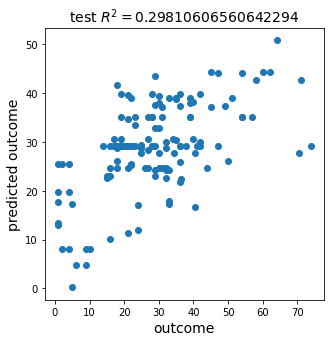

In [28]:
# plot how the y_test_hat changes with y_test 
plt.figure(figsize=[5, 5])
plt.plot(y_test, y_test_hat, 'o')
plt.xlabel('outcome', fontsize=14)
plt.ylabel('predicted outcome', fontsize=14)
plt.title(r'test $R^2 = {}$'.format(cv_metrics['R2']), fontsize=14)
plt.show()

In [29]:
# plot how the y_cv changes with y_cv 
plt.figure(figsize=[5, 5])
plt.plot(y, y_cv, 'o')
plt.xlabel('outcome', fontsize=14)
plt.ylabel('predicted outcome', fontsize=14)
plt.title(r'CV $R^2 = {}$'.format(cv_metrics['R2']), fontsize=14)
plt.show()

## Extract the coeficient from the model
For linear models, the coefficient represent the contribution of the feature to the prediction. For tree based models, you can also extract feature importance measure for each feature. For SVM model, you can generate permuation based feature importance for each feature. Check the document of Sklearn to find it out.

In [22]:
# the coefficients in ElasticNet can be extracted in this way
coeffs = selected_model['model'].coef_
print(coeffs.shape)

# extract the name and coeffs of the nonzero coefficients
coeffs_df = pd.DataFrame(
    {'name': np.array(feature_names),
    'coef': coeffs,
    'coef_abs': np.abs(coeffs)
    }
).sort_values('coef_abs', axis=0, ascending=False)
print('{} nonzeros coefficients are selected'.format( (coeffs_df.coef_abs > 0).sum() ))
coeffs_df.head(10)

(19,)
17 nonzeros coefficients are selected


name      coef  coef_abs
3     Pclass_3 -7.606544  7.606544
2     Pclass_2 -3.972926  3.972926
11     Parch_2 -3.506938  3.506938
1   Survived_1 -2.266804  2.266804
8      SibSp_4 -1.802689  1.802689
10     Parch_1 -1.635371  1.635371
6      SibSp_2 -1.004418  1.004418
7      SibSp_3 -0.932393  0.932393
14     Parch_5  0.752292  0.752292
17  Embarked_S  0.687821  0.687821

## Save the model

In [23]:
# You can also save the model for future usage
import joblib

joblib.dump(selected_model, filename='results/selected_model.pkl')

['results/selected_model.pkl']

In [24]:
# You can load the saved the model
import joblib

selected_model = joblib.load(filename='results/selected_model.pkl')
print(selected_model)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 ElasticNet(alpha=0.12648552168552957, l1_ratio=0.95))])
